In [132]:
import numpy as np
import neurofit as nf
from spyks import models
import neurofit.cneurons as cn
from scipy.signal import resample

In [162]:
# Load driving current
I = np.loadtxt("../dstrf/data/real/20120116_1_1_6i.dat")
I = resample(I,len(I)/5)
I = I[:31000]*1000
dt = 0.1

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.57 ms


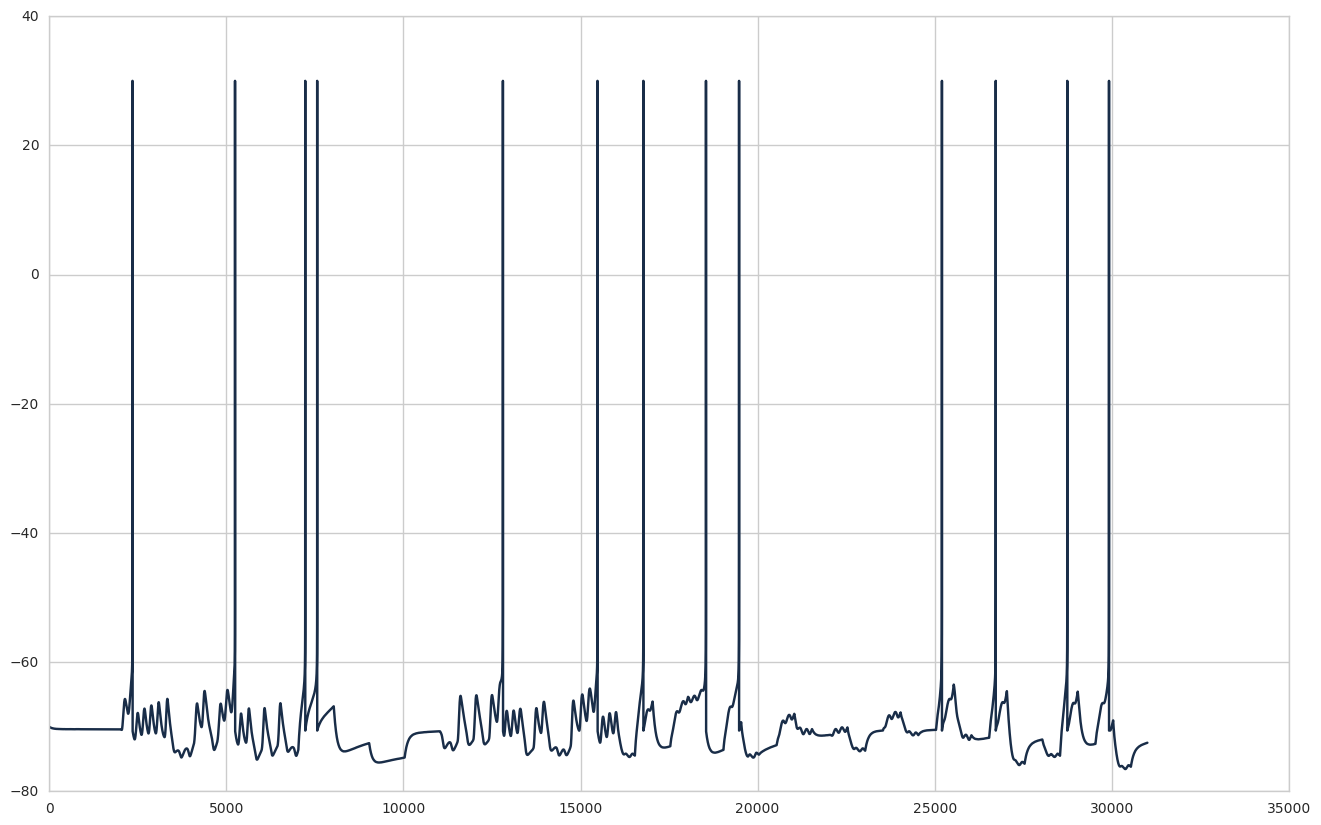

In [244]:
# Generate data for twin experiment
true = [250, 30, -70.6, 2.0, -66, 144, 4, -70.6, 80.5, 30, 1]
twin = models.AdEx(true, models.timeseries(I, dt))
%time data = models.integrate_adex(twin, x0, dt)[:,0]
plot(data)

In [245]:
# Make AdEx class for neurofit
class AdEx:
    def __init__(self,dt=1,x0=[-70,0],R=1,h=30):
        self.dt = dt
        self.x0 = x0
        self.params = None
        self.R = 1
        self.h = 30
        
    def set(self,theta):
        self.params = np.hstack((theta,[self.h,self.R]))
    
    def run(self,stim):
        model = models.AdEx(self.params,models.timeseries(stim,self.dt))
        return models.integrate_adex(model,self.x0,self.dt)[:,0]

In [246]:
bounds = [[   1, 500],
          [   0,  30],
          [-120, -40],
          [ 0.5,  10],
          [ -70,   0],
          [   1, 210],
          [ -10,  10],
          [ -80,   0],
          [   0, 500]]

out = nf.fit([[data]],[I],AdEx(dt=dt),nf.priors.uniform(bounds),
        nf.costs.mean_squared_error,1000,1000,1,
        nf.startpos.uniform(bounds,1000),threads=1,
        progress_bar=True)

 [##########] 1000 samples in 16:34

In [247]:
maxlik = out.flatchain[np.argmax(out.flatlnprobability)]

In [248]:
import corner
names = ["C", "gl", "el", "delt", "vt", "tw", "a", "vr", "b"]
pandas.DataFrame(data=zip(true[:-2],maxlik),index=names,columns=["true","fit"])

,true,fit
C,250.0,241.647377
gl,30.0,27.550675
el,-70.6,-71.600018
delt,2.0,0.836885
vt,-66.0,-23.991563
tw,144.0,66.691056
a,4.0,7.274621
vr,-70.6,-72.529828
b,80.5,190.952081


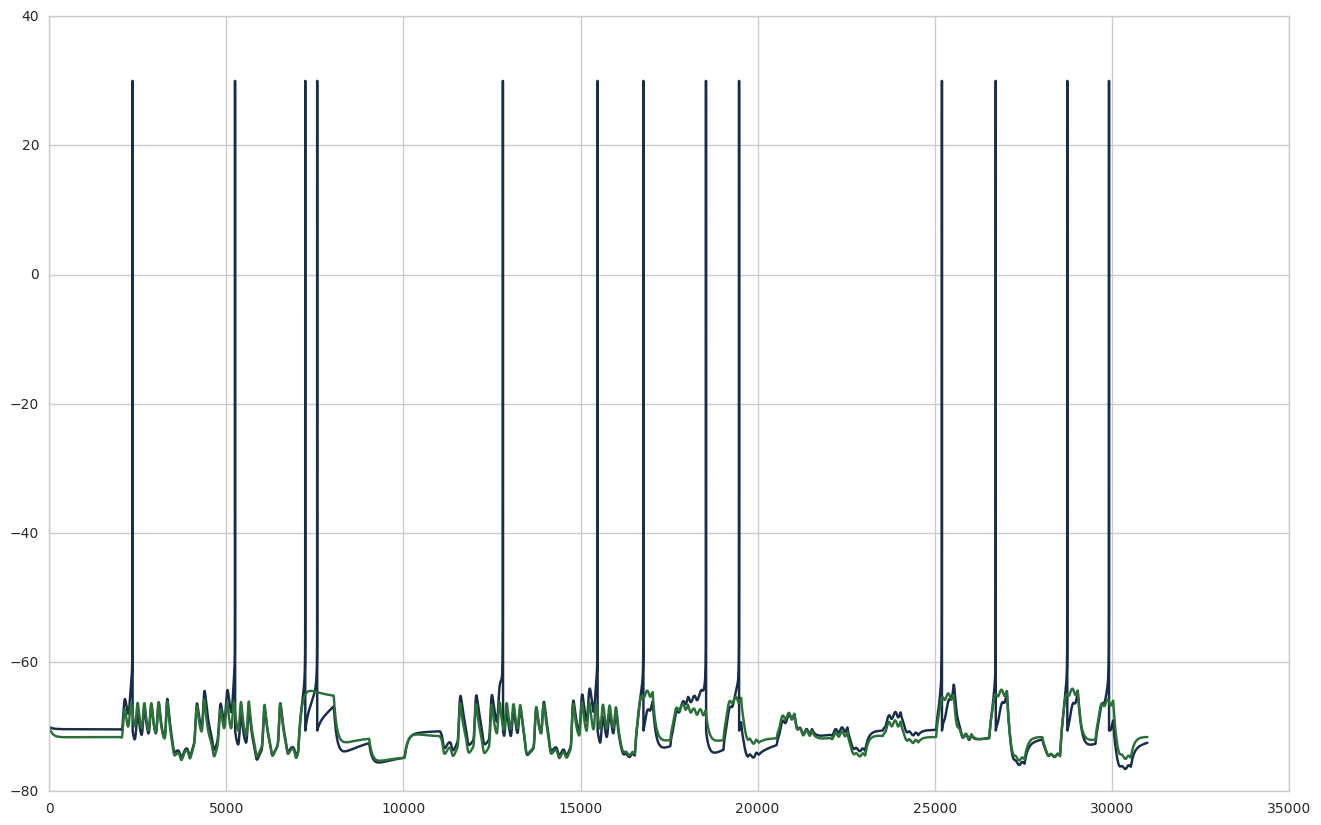

In [249]:
maxlik_model = AdEx(dt=0.1)
maxlik_model.set(maxlik)
predict = maxlik_model.run(I)
plot(data,label="data")
plot(predict,label="predict")